# MovieLens 100K: Sistem preporuka zasnovan na uzajamnom filtriranju koristeći matricu kovarijansi

Sistem preporuka je sistem koji preporučuje proizvode korisniku za koje smatra da su mu od značaja. Ovi sistemi su široko rasprostranjeni i korišćeni u različitim sferama života. Postoji više različitih vrsta takvih sistema, ovde će biti korišćen sistem zasnovan na **uzajamnom filtriranju**. Osnovna ideja uzajamnog filtriranja je da ako su korisnici imali slična interesovanja u prošlosti imaće slična interesovanja i u budućnosti, tj. da prethodno ponašanje korisnika ima ogroman uticaj na njegovo buduće ponašanje. 

Kako se ocenjuje sličnost među korisnicima? Konstruiše se matrica sličnosti, gde se sličnost može izračunati korišćenjem različitih metrika. Među korišćenim metrikama najpopularnije su kosinusna funkcija sličnosti, Pirsonov koeficijent korelacije, Žakardov indeks, razlika srednjih kvadrata, kombinacija razlike srednjih kvadrata i Žakardovog indeksa, itd. Međutim, ovakav pristup uzajamnom filtriranju može imati nekoliko problema:

**1) Kvalitet sistema preporuka zasnovanom na uzajamnom filtriranju može umnogome zavisiti od retkosti podataka.**

**2) Sistem se teško prilagođava situaciji kada se interesovanja korisnika menjaju tokom vremena.**

**3) Sistem preporučuje slične proizvode korisniku ignorišiću korisnikovu potrebu za raznolikošću.**

Zbog navedenih problema preporučen je novi pristup uzajamnom filtriranju koji se ne zasniva na matrici sličnosti među korisnicima, nego na matrici kovarijansi. Ovaj rad je zasnovan na naučnom radu koji se može pronaći na sledećoj adresi: https://www.hindawi.com/journals/mpe/2018/9740402/.

U njemu je predložen algoritam CFCM (Collaborative Filtering Covariance Matrix) kojim se rešavaju prethodno navedeni problemi i poboljšava se kvalitet preporuka. Naš zadatak je da implementiramo navedeni algoritam i da evaluiramo njegove performanse.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Koristićemo dostupan skup podataka pod imenom MovieLens u veličini od 100 000. Skup podataka se može naći na: https://grouplens.org/datasets/movielens/100k/.

U naučnom radu na kome se zasniva ovaj rad korišćen je skup podataka MovieLens 1M, koji se sastoji od jednog miliona podataka. Mi smo istraživanje odradile na ovom skupu od 100 000 zbog hardverskih ograničenja, ali i zbog već dostupnih trening i test podataka.

In [2]:
header = ['user', 'item', 'rating', 'timestamp']

Učitavamo ceo skup podataka.

In [3]:
data = pd.read_csv('ml-100k/u.data', sep = '\\t', names = header, engine = 'python')

In [4]:
data.head()

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user       100000 non-null  int64
 1   item       100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


Proveravamo koliko različitih korisnika i filmova imamo.

In [6]:
number_of_users = data['user'].unique().shape[0]
number_of_users

943

In [7]:
number_of_items = data['item'].unique().shape[0]
number_of_items

1682

Formiramo USER-ITEM matricu podataka. Redovi predstavljaju korisnike, a kolone filmove, dok polja matrice odgovaraju ocenama koje je odgovarajući korisnik dao odgovarajućem filmu.

In [8]:
ui_matrix = pd.pivot_table(data, index = 'user', columns = 'item', values = 'rating')

In [9]:
ui_matrix

item,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
ui_matrix.describe()

item,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
count,452.000000,131.000000,90.000000,209.000000,86.000000,26.000000,392.000000,219.000000,299.000000,89.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,3.878319,3.206107,3.033333,3.550239,3.302326,3.576923,3.798469,3.995434,3.896321,3.831461,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0
std,0.927897,0.966497,1.212760,0.965069,0.946446,1.301478,0.982037,1.002281,1.042368,1.013948,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0
25%,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0
50%,4.000000,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0
75%,5.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0


Možemo videti da je USER-ITEM matrica veoma retka što potpada pod jedan od navedenih problema.

Učitavamo dostupne trening podatke.

In [11]:
train_data = pd.read_csv('ml-100k/u1.base', sep = '\\t', names = header, engine = 'python')

In [12]:
train_data.head()

,user,item,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [13]:
train_data.shape

(80000, 4)

Učitavamo dostupne test podatke koji odgovaraju učitanim trening podacima.

In [14]:
test_data = pd.read_csv('ml-100k/u1.test', sep = '\\t', names = header, engine = 'python')

In [15]:
test_data.head()

,user,item,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


### Vizualiazacija podataka

In [16]:
genres = pd.read_csv('ml-100k/u.genre', sep = '|', names=['genre', 'id'], engine = 'python')

In [17]:
movies_header = ['item', 'title', 'date1', 'date2', 'url'] + [g for g in genres['genre']]

In [18]:
movies_header

['item',
 'title',
 'date1',
 'date2',
 'url',
 'unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [19]:
movies = pd.read_csv('ml-100k/u.item', sep = '|', names = movies_header, engine = 'python')

In [20]:
movies.head()

,item,title,date1,date2,url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [21]:
del movies['date1']
del movies['date2']
del movies['url']
movies.head()

,item,title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [22]:
train_data_movies = pd.merge(train_data, movies, on = 'item')

In [23]:
train_data_movies.head()

,user,item,rating,timestamp,title,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,5,874965758,Toy Story (1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,1,4,888550871,Toy Story (1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,6,1,4,883599478,Toy Story (1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,13,1,3,882140487,Toy Story (1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,16,1,5,877717833,Toy Story (1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [24]:
train_data_movies.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Marlene Dietrich: Shadow and Light (1996)            5.000000
Prefontaine (1997)                                   5.000000
Someone Else's America (1995)                        5.000000
They Made Me a Criminal (1939)                       5.000000
Saint of Fort Washington, The (1993)                 5.000000
Santa with Muscles (1996)                            5.000000
Star Kid (1997)                                      5.000000
Entertaining Angels: The Dorothy Day Story (1996)    5.000000
Pather Panchali (1955)                               4.714286
Faust (1994)                                         4.666667
Name: rating, dtype: float64

In [25]:
train_data_movies.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

title
Star Wars (1977)                 484
Return of the Jedi (1983)        422
Contact (1997)                   402
Fargo (1996)                     395
Liar Liar (1997)                 394
Scream (1996)                    391
English Patient, The (1996)      388
Toy Story (1995)                 383
Independence Day (ID4) (1996)    353
Air Force One (1997)             352
Name: rating, dtype: int64

In [26]:
ratings = pd.DataFrame(train_data_movies.groupby('title')['rating'].mean())
ratings['count'] = pd.DataFrame(train_data_movies.groupby('title')['rating'].count())
ratings = pd.merge(ratings, movies, on='title')
ratings.sort_values(by='count', ascending=False).head(10)

,title,rating,count,item,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1388,Star Wars (1977),4.359504,484,50,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
1223,Return of the Jedi (1983),4.011848,422,181,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
334,Contact (1997),3.823383,402,258,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
497,Fargo (1996),4.108861,395,100,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
855,Liar Liar (1997),3.164975,394,294,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1273,Scream (1996),3.445013,391,288,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
461,"English Patient, The (1996)",3.641753,388,286,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1513,Toy Story (1995),3.892950,383,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
741,Independence Day (ID4) (1996),3.390935,353,121,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
31,Air Force One (1997),3.656250,352,300,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


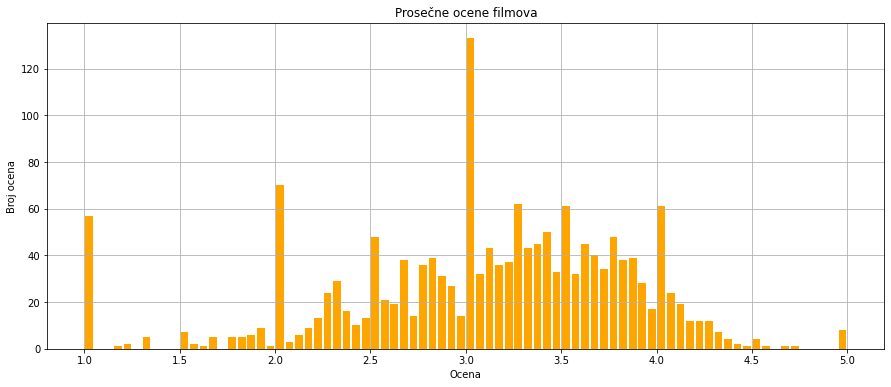

In [27]:
plt.figure(figsize=(15, 6))
ratings['rating'].hist(bins=80, rwidth=0.8, color='orange')
plt.xlabel('Ocena')
plt.ylabel('Broj ocena')
plt.title('Prosečne ocene filmova')
plt.show()

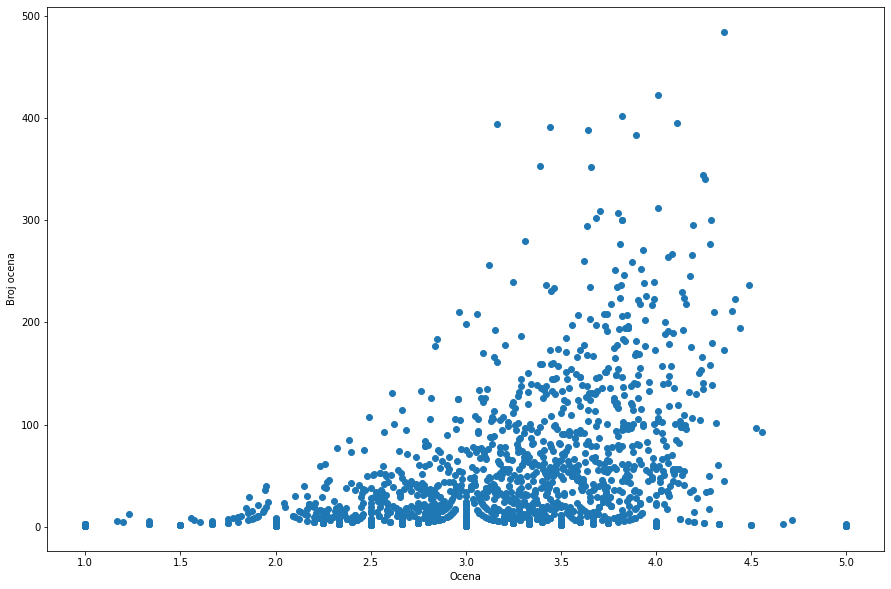

In [28]:
plt.figure(figsize=(15, 10))
plt.scatter(x = ratings['rating'], y = ratings['count'])
plt.xlabel('Ocena')
plt.ylabel('Broj ocena')
plt.show()

In [29]:
number_of_ratings_for_genre = {}
for x in genres['genre']:
    number_of_ratings_for_genre[x] = len(np.where(np.array(train_data_movies[x]) == 1)[0])

In [30]:
number_of_ratings_for_genre

{'unknown': 3,
 'Action': 20566,
 'Adventure': 11131,
 'Animation': 2893,
 "Children's": 5779,
 'Comedy': 23896,
 'Crime': 6446,
 'Documentary': 570,
 'Drama': 31989,
 'Fantasy': 1090,
 'Film-Noir': 1394,
 'Horror': 4187,
 'Musical': 3966,
 'Mystery': 4208,
 'Romance': 15547,
 'Sci-Fi': 10241,
 'Thriller': 17438,
 'War': 7613,
 'Western': 1480}

In [31]:
average_ratings_for_genres = []

for x in genres['genre']:
    average_ratings_for_genres.append(ratings[ratings[x].apply(lambda y: y == 1)].mean().rating)

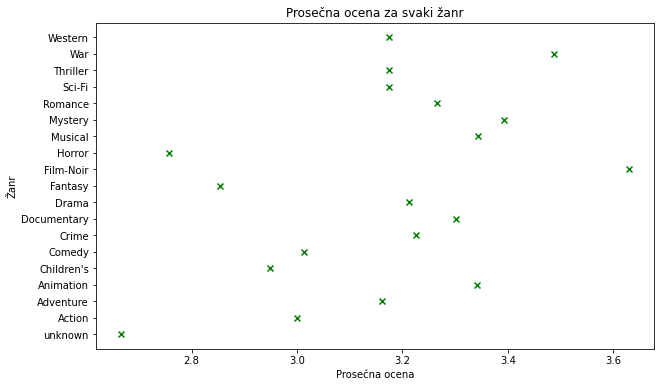

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(x = average_ratings_for_genres, y = [g for g in genres['genre']], color='green', marker='x')
plt.ylabel('Žanr')
plt.xlabel('Prosečna ocena')
plt.title('Prosečna ocena za svaki žanr')
plt.show()

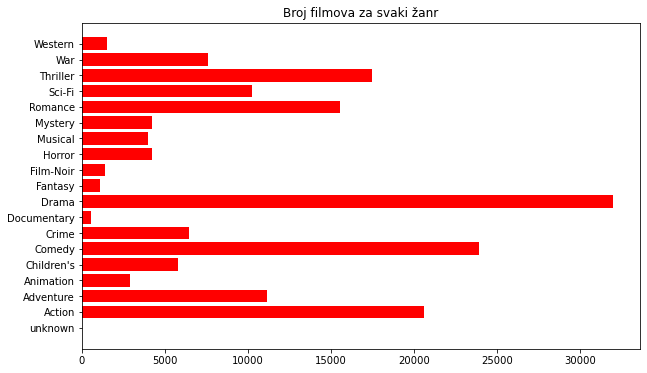

In [33]:
plt.figure(figsize=(10, 6))
plt.barh([g for g in genres['genre']], list(number_of_ratings_for_genre.values()), color='red')
plt.title('Broj filmova za svaki žanr')
plt.show()

### Rad sa podacima

Formiramo USER-ITEM matricu nad trening podacima (na drugačiji način nego nad svim podacima, zbog toga što u trening podacima se ne nalaze svi filmovi, a nama je potrebno da ih imamo u toj matrici pa ih dodajemo ovde sa svim vrednostima 0 u matrici).

In [34]:
ui_matrix_train = np.zeros((number_of_users, number_of_items))
for row in train_data.itertuples():
    ui_matrix_train[row[1]-1, row[2]-2] = row[3]
    
ui_matrix_train.shape

(943, 1682)

In [35]:
ui_matrix_train

array([[3., 4., 3., ..., 0., 0., 5.],
       [0., 0., 0., ..., 0., 0., 4.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 5.],
       [0., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

Ukupno svih filmova imamo 1682, a u trening skupu ih imamo 1650.

In [36]:
number_of_items

1682

In [37]:
train_data['item'].unique().shape[0]

1650

Broj različitih korisnika u trening skupu.

In [38]:
train_data['user'].unique().shape[0]

943

Broj različitih korisnika u test skupu.

In [39]:
test_data['user'].unique().shape[0]

459

Računamo vrednost kovarijanse između dva korisnika na osnovu sledeće formule:

\begin{align}
 cov(u_{i}, u_{j}) = \frac{1}{|I|}\sum_{k \in (I_{i} \cap I_{j})} r_{ik} \bullet r_{jk} - \frac{1}{|I|^2} \sum_{k \in I} r_{ik} \bullet \sum_{k \in I} r_{jk}
\end{align}

In [40]:
def calculate_covariance_between_users(ui_matrix, i, j):
    if (i != j):
        ratings_i = ui_matrix[i,:]
        ratings_j = ui_matrix[j,:]
    
        common_items = (ratings_i != 0) & (ratings_j != 0)
    
        part1 = np.sum(ratings_i[common_items]*ratings_j[common_items])*(1/number_of_items)
        part2 = np.sum(ratings_i)*np.sum(ratings_j)*(1/(number_of_items**2))
    
        return part1 - part2
    else:
        return float('inf')

In [41]:
calculate_covariance_between_users(ui_matrix_train, 1, 2)

0.008566609310867957

In [42]:
calculate_covariance_between_users(ui_matrix_train, 2, 1)

0.008566609310867957

In [43]:
calculate_covariance_between_users(ui_matrix_train, 100, 99)

-0.004150401325640022

Formiramo matricu kovarijanse za svaka dva korisnika koristeći prethodno definisanu funkciju koja računa kovarijansu između dva korisnika. S obzirom na to da je matrica simetrična, dovoljno je računati samo pola matrice.

In [44]:
covariance_matrix = np.zeros((number_of_users, number_of_users))
for i in range(number_of_users):
    for j in range(i, number_of_users):
        covariance_matrix[i, j] = calculate_covariance_between_users(ui_matrix_train, i, j)
        covariance_matrix[j, i] = covariance_matrix[i, j]

In [45]:
covariance_matrix

array([[        inf,  0.03810155,  0.00961923, ...,  0.06700484,
         0.07872932,  0.21979136],
       [ 0.03810155,         inf,  0.00856661, ...,  0.03326825,
         0.05383221,  0.03996361],
       [ 0.00961923,  0.00856661,         inf, ...,  0.01400433,
         0.02209871, -0.00750055],
       ...,
       [ 0.06700484,  0.03326825,  0.01400433, ...,         inf,
         0.03458279,  0.03369842],
       [ 0.07872932,  0.05383221,  0.02209871, ...,  0.03458279,
                inf,  0.12853484],
       [ 0.21979136,  0.03996361, -0.00750055, ...,  0.03369842,
         0.12853484,         inf]])

In [46]:
covariance_matrix[10, 20]

0.008439714908218932

In [47]:
covariance_matrix[20, 10]

0.008439714908218932

In [48]:
covariance_matrix[942, 0]

0.21979135591087556

In [49]:
covariance_matrix[0, 942]

0.21979135591087556

Definišemo funkciju koja vraća K najličnijih korisnika korisniku koji se prosleđuje kao argument.

In [50]:
def GetKSimilarUser(user_i, K):
    user_values = covariance_matrix[user_i,:]
    values = user_values.argsort()[-K-1:]
    
    return values[0:K]

In [51]:
print(GetKSimilarUser(0, 10))
for i in GetKSimilarUser(0,10):
    print(covariance_matrix[0, i])

[415 888 746 605 456 513 473 822 863 591]
0.4247661113475408
0.43463771824776853
0.44647318392548363
0.44853106473947413
0.4494610345817291
0.45235804439819527
0.47118436660959356
0.4804091301759837
0.49576618062693606
0.5263399554066912


Definišemo funkciju koja vraća K najrazličitijih korisnika korisniku koji se prosleđuje kao argument.

In [52]:
def GetKDSimilarUser(user_i, K):
    user_values = covariance_matrix[user_i,:]
    
    return user_values.argsort()[:K]

Formiramo niz koji za svakog korisnika iz trening skupa sadrži prosek ocena koje je dao filmovima koje je gledao.

In [53]:
train_users = train_data['user'].unique()
average_ratings = np.zeros(number_of_users)

for user in train_users:
    average_ratings[user-1] = ui_matrix_train[user-1, ui_matrix_train[user-1, :] != 0].mean()
    
average_ratings
    

array([3.68148148, 3.8       , 3.        , 4.35714286, 2.95604396,
       3.58181818, 3.89201878, 3.6       , 4.16666667, 4.21276596,
       3.53333333, 4.28      , 3.13672922, 4.2195122 , 3.03333333,
       4.34782609, 3.15789474, 3.93710692, 3.6       , 3.30769231,
       2.66315789, 3.3       , 3.63636364, 4.3902439 , 4.04878049,
       2.90909091, 3.3       , 3.64102564, 3.94117647, 3.8       ,
       3.91304348, 3.54545455, 3.64285714, 3.8       , 3.        ,
       4.        , 3.45945946, 3.9047619 , 3.84615385, 2.72727273,
       3.93548387, 3.625     , 3.67857143, 3.6375    , 3.48275862,
       4.18181818, 3.5625    , 3.72727273, 2.72897196, 3.53846154,
       3.75      , 4.34285714, 4.        , 3.33333333, 3.8       ,
       3.65217391, 3.62962963, 3.875     , 4.02325581, 4.13445378,
       2.83333333, 3.31707317, 2.97916667, 3.59633028, 3.97916667,
       3.52380952, 3.41666667, 3.16666667, 3.73684211, 3.4025974 ,
       3.81818182, 3.76712329, 3.64705882, 3.76190476, 3.18181

Predloženi algoritam

In [54]:
def CFCM(UI, user_u, alpha, K, N):
    Nus = GetKSimilarUser(user_u-1, K)
    Nud = GetKDSimilarUser(user_u-1, K)
    
    # pronalazimo iteme koje korisnik nije ocenio i nad njima primenjujemo algoritam
    unrated_items = np.where(UI[user_u-1, :] == 0)[0]
    number_of_unrated_items = unrated_items.shape[0]
    # rečnik predvidjenih ocena za sve iteme
    all_predicted_ratings = {}
    # drugo, krace ime za matricu kovarijansi
    COV = covariance_matrix
    
    
    for item_i in unrated_items:
        
        # za racunanje dela iznad razlomacke crte u prvom delu gde se posmatraju slicni
        similar = np.zeros(K)
        # za racunanje dela ispod razlomacke crte u prvom delu gde se posmatraju slicni
        divide_s = np.zeros(K)
        # za racunanje dela iznad razlomacke crte u drugom delu gde se posmatraju razliciti
        disimilar = np.zeros(K)
        # za racunanje dela ispod razlomacke crte u drugom delu gde se posmatraju razliciti
        divide_ds = np.zeros(K)
    
        for i in range(K):
            if alpha != 0:
                similar[i] = COV[user_u-1, Nus[i]]*(UI[Nus[i],item_i] - average_ratings[Nus[i]])
                divide_s[i] = np.abs(COV[user_u-1, Nus[i]])
            if alpha != 1:
                disimilar[i] = np.abs(COV[user_u-1, Nud[i]])*(UI[Nud[i],item_i] - average_ratings[Nud[i]])
                divide_ds[i] = np.abs(COV[user_u-1, Nud[i]])
        
        # formula iz algoritma
        if (alpha != 0 and alpha != 1):
            rui = average_ratings[user_u-1] + alpha * (np.sum(similar)/np.sum(divide_s)) + (1-alpha) * (np.sum(disimilar)/np.sum(divide_ds))
        elif (alpha == 0):
            rui = average_ratings[user_u-1] + (1-alpha) * (np.sum(disimilar)/np.sum(divide_ds))
        elif (alpha == 1):
            rui = average_ratings[user_u-1] + alpha * (np.sum(similar)/np.sum(divide_s))
        
        # za svaki element stavljamo u niz
        all_predicted_ratings[item_i+1] = rui
        #print(rui) 
        
    # uzimamo prvih N najboljih predloga za usera u     
    sorted_ratings = sorted(all_predicted_ratings.items(), key=lambda x: x[1], reverse=True)
    sorted_i = [rating[0] for rating in sorted_ratings[:N]]
    sorted_r = [rating[1] for rating in sorted_ratings[:N]]
    
    # rezultat je lista parova itema i njihovih ocena
    Result = list(zip(sorted_i, sorted_r))
    return Result

In [55]:
CFCM(ui_matrix_train, 200, 0.8, 10, 5)

[(173, 4.2870704319383055),
 (49, 4.132586341708102),
 (81, 4.064823508159774),
 (180, 3.9695336703784125),
 (95, 3.9000457126344017)]

In [56]:
CFCM(ui_matrix_train, 1, 0.8, 10, 5)

[(97, 3.759914892335842),
 (422, 3.686520019266224),
 (99, 3.681752439250074),
 (95, 3.522095216899382),
 (96, 3.508205710685873)]

Definišemo funkciju koja primenjuje naš algoritam za dato alfa, K i N.

In [57]:
def recommendToTestUsers(alpha, K, N):
    users = test_data['user'].unique()
    
    R = {}
    
    for user in users:
        R[user] = CFCM(ui_matrix_train, user, alpha = alpha, K = K, N = N)
        
    return R

Za svakog test korisnika vraćamo filmove koje je gledao i ocene koje im je dao.

In [58]:
def getTestItems():
    test_users = test_data['user'].unique()
    T = {}
    for test_user in test_users:
        T[test_user] = list(zip(np.array(test_data[test_data['user'] == test_user]['item']), np.array(test_data[test_data['user'] == test_user]['rating'])))

    return T

In [59]:
test_data

,user,item,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198
...,...,...,...,...
19995,458,648,4,886395899
19996,458,1101,4,886397931
19997,459,934,3,879563639
19998,460,10,3,882912371


Definišemo funkciju za računanje metrike F1.

In [60]:
def getF1(R, T):
    test_users = test_data['user'].unique()
    number_of_test_users = test_data['user'].unique().shape[0]
    
    A = np.zeros(number_of_test_users)
    B = np.zeros(number_of_test_users)
    C = np.zeros(number_of_test_users)
    i = 0
    for test_user in test_users:
        A[i] = len(set([t[0] for t in T[test_user]]) & set([r[0] for r in R[test_user]]))
        B[i] = len(T[test_user])
        C[i] = len(R[test_user])
        i = i + 1
        
    Recall = np.sum(A)/np.sum(B)
    Precision = np.sum(A)/np.sum(C)
    
    return 2 / (1/Precision + 1/Recall)

Definišemo funkcije za računanje metrike MAE. Prilikom primene algoritma će se računati metrika NMAE (u funkciji applyAlgorithm), normalizacijom rezultata funkcije getMAE.

In [61]:
def getRating(X, item):
    for x in X:        
        if (x[0] == item):
            return x[1]
    return inf

In [62]:
def getMAE(R, T):
    S = 0
    Num = 0
    for test_user in T:
        test_items = [x[0] for x in T[test_user]]
        
        recommended_items = [y[0] for y in R[test_user]]
        
        A = set(test_items) & set(recommended_items)
        Num += len(A)
        if (len(A)):
            for item in A:
                S += abs(getRating(T[test_user], item) - getRating(R[test_user], item))

    return S/Num          

Definišemo funkcije za računanje diverziteta.

In [63]:
def findUsersForItem(item):
    x = np.array([u != 0 for u in ui_matrix_train[:, item - 1]])
    return set(np.where(x == True)[0])

In [64]:
def jaccard_similarity(items_of_user):
    S = 0
    
    for i in range(len(items_of_user)):
        for j in range(len(items_of_user)):
            if (i < j):
                users_i = findUsersForItem(items_of_user[i])
                users_j = findUsersForItem(items_of_user[j])
                
                S += len(users_i & users_j)/len(users_i | users_j)
                
    return S

In [65]:
def getDiversity(R):
    number_of_test_users = test_data['user'].unique().shape[0]    
    result = np.zeros(number_of_test_users)
    i = 0

    for r in R:
        items_of_user = [x[0] for x in R[r]]
        result[i] = 1 - (jaccard_similarity(items_of_user))/((1/2) * len(R[r]) * (len(R[r]) - 1))
        i = i + 1
        
    Diversity = np.sum(result) / number_of_test_users
        
    return Diversity

Primenjujemo algoritam za različite vrednosti parametara i pamtimo evaluacije za svaku od tih kombinacija parametara.

In [66]:
def applyAlgorithm(k):
    T = getTestItems()
    alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    F1s = []
    MAEs = []
    NMAEs = []
    Ds = []

    print(k)
    for alpha in alphas:
        print(alpha)

        R = recommendToTestUsers(alpha = alpha, K = k, N = 20)

        F1 = getF1(R, T)
        F1s.append(F1)

        MAE = getMAE(R, T)
        MAEs.append(MAE)
        NMAEs.append(MAE * (1/(5-1)))

        diversity = getDiversity(R)
        Ds.append(diversity)

    evaluations = list(zip(alphas, F1s, MAEs, NMAEs, Ds))
    
    return evaluations   

In [67]:
%%time
evaluations = {}
evaluations[5] = applyAlgorithm(5)
print(evaluations[5])

5
0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1
[(0, 0.018437285812200138, 1.3438927069568065, 0.33597317673920163, 0.7776764401651871), (0.1, 0.019191226867717612, 1.3573566576266338, 0.33933916440665846, 0.7702305823463573), (0.2, 0.020493488690884163, 1.4272387865886806, 0.35680969664717016, 0.7626155238187183), (0.3, 0.021453050034270046, 1.5001580196699382, 0.37503950491748456, 0.7549036900121401), (0.4, 0.02618231665524332, 1.5388855920832676, 0.3847213980208169, 0.74671962182454), (0.5, 0.03495544893762851, 1.4686992027060695, 0.36717480067651737, 0.7451030643789038), (0.6, 0.045305003427004796, 1.306664317139262, 0.3266660792848155, 0.7450759894500999), (0.7, 0.050925291295407814, 1.1256895658726864, 0.2814223914681716, 0.7430661771429908), (0.8, 0.0527073337902673, 0.9511370978501542, 0.23778427446253855, 0.7429124734988501), (0.9, 0.054078135709389984, 0.8580243320134263, 0.21450608300335658, 0.7448781236480191), (1, 0.05490061686086361, 0.8598021706960599, 0.21495054267401498, 0.7

In [68]:
%%time
evaluations[15] = applyAlgorithm(15)
print(evaluations[15])

15
0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1
[(0, 0.018505825908156272, 1.765502965460897, 0.44137574136522423, 0.7488400128835339), (0.1, 0.019465387251542156, 1.8051421502731442, 0.45128553756828604, 0.7408190141440582), (0.2, 0.020904729266620976, 1.8616679517247812, 0.4654169879311953, 0.7320754396563309), (0.3, 0.023783413296778615, 1.9254251529672148, 0.4813562882418037, 0.7218829084377142), (0.4, 0.02988348183687457, 1.907522899124423, 0.47688072478110577, 0.7118644578447673), (0.5, 0.038382453735435224, 1.8058089033418139, 0.45145222583545347, 0.706861619885881), (0.6, 0.04653872515421522, 1.5808139138432065, 0.3952034784608016, 0.7060526464341216), (0.7, 0.05078821110349555, 1.3414783968207162, 0.33536959920517906, 0.7059323154151691), (0.8, 0.05318711446196025, 1.1210805540369022, 0.28027013850922555, 0.7055660390200201), (0.9, 0.054420836189170665, 0.9701704592144681, 0.24254261480361702, 0.7068233669445994), (1, 0.054420836189170665, 0.8879314633386834, 0.22198286583467086, 0

In [69]:
%%time
evaluations[25] = applyAlgorithm(25)
print(evaluations[25])

25
0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1
[(0, 0.01884852638793694, 1.9414218210659457, 0.48535545526648644, 0.739988445485952), (0.1, 0.01973954763536669, 1.9561827431303778, 0.48904568578259444, 0.7317155861051592), (0.2, 0.021384509938313916, 2.0048261864130357, 0.5012065466032589, 0.7217651235813217), (0.3, 0.02446881425633996, 2.054062851359275, 0.5135157128398188, 0.711547808402397), (0.4, 0.030843043180260456, 2.0532357344903844, 0.5133089336225961, 0.7010025805471509), (0.5, 0.038862234407128174, 1.8691284146643927, 0.4672821036660982, 0.693633763762826), (0.6, 0.04626456477039068, 1.6491947912697813, 0.4122986978174453, 0.6943400156049708), (0.7, 0.05133653187114461, 1.4052740847162215, 0.3513185211790554, 0.6958484840315239), (0.8, 0.053666895133653185, 1.1976538837770985, 0.2994134709442746, 0.6958767850372843), (0.9, 0.053529814941740916, 1.0351947551838485, 0.25879868879596213, 0.696378737879087), (1, 0.053666895133653185, 0.9303263909874566, 0.23258159774686415, 0.697339

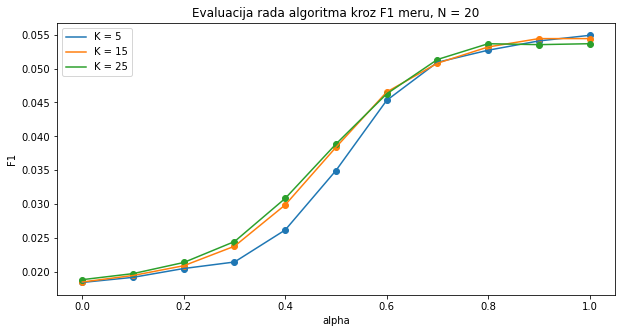

In [70]:
plt.figure(figsize = (10, 5))
plt.title('Evaluacija rada algoritma kroz F1 meru, N = 20')
plt.plot([element[0] for element in evaluations[5]], [element[1] for element in evaluations[5]], label = 'K = 5')
plt.scatter([element[0] for element in evaluations[5]], [element[1] for element in evaluations[5]])
plt.plot([element[0] for element in evaluations[15]], [element[1] for element in evaluations[15]], label = 'K = 15')
plt.scatter([element[0] for element in evaluations[15]], [element[1] for element in evaluations[15]])
plt.plot([element[0] for element in evaluations[25]], [element[1] for element in evaluations[25]], label = 'K = 25')
plt.scatter([element[0] for element in evaluations[25]], [element[1] for element in evaluations[25]])
plt.legend(loc = 'best')
plt.xlabel('alpha')
plt.ylabel('F1')
plt.show()

Posmatrajući F1 meru vidimo da ona raste kako raste alfa, za bilo koje K. To je očekivano s obzirom na to da povećavanje alfe dajemo više značaja korisnicima koji su najsličniji i samim tim povećavamo preciznost predikcije. Što se K vrednosti tiče, vidimo da nema velike razlike u uticaju na predikciju. Kada je alfa između 0.2 i 0.6, vidimo da je predikcija za K = 5 malo lošija od ostalih i da F1 za svako K brže raste nego van tog intervala. Za alfa od 0.6 do 1, nema velikih odstupanja za različita K. Međutim, ono što primećujemo je da je vrednost za F1 na celom grafiku loša. Najmanja vrednost je negde između 0 i 0.02, a najveća nešto iznad 0.05. S obzirom na to da se F1 kreće od 0 do 1, ovi rezultati nisu dobri.

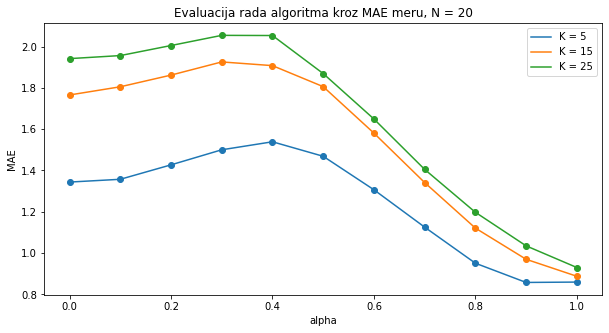

In [71]:
plt.figure(figsize = (10, 5))
plt.title('Evaluacija rada algoritma kroz MAE meru, N = 20')
plt.plot([element[0] for element in evaluations[5]], [element[2] for element in evaluations[5]], label = 'K = 5')
plt.scatter([element[0] for element in evaluations[5]], [element[2] for element in evaluations[5]])
plt.plot([element[0] for element in evaluations[15]], [element[2] for element in evaluations[15]], label = 'K = 15')
plt.scatter([element[0] for element in evaluations[15]], [element[2] for element in evaluations[15]])
plt.plot([element[0] for element in evaluations[25]], [element[2] for element in evaluations[25]], label = 'K = 25')
plt.scatter([element[0] for element in evaluations[25]], [element[2] for element in evaluations[25]])
plt.legend(loc = 'best')
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.show()

MAE (Mean Absolute Error) za svako K sporo raste dok ne dođe do alfa = 0.4, potom opada što je zapravo i očekivano ponašanje s obzirom na to da MAE predstavlja grešku predikcije a ona opada kako sve više uzimamo u obzir najsličnije korisnike. Što je K veće pad je drastičniji. Možemo primetiti da što je veće K i greška je veća. Posmatrajući celokupnu MAE meru možemo videti da kreće od 0.8 do 2. Za alfa = 0.8 i K = 5 algoritam u proseku greši 0.95 što znači da pogrešno predviđa ocenu za 0.95 veću ili manju. Takođe, povećanje greške povećanjem vrednosti K nema smisla, jer bi predikcija trebalo da preciznija kada se uzme u obzir više suseda.

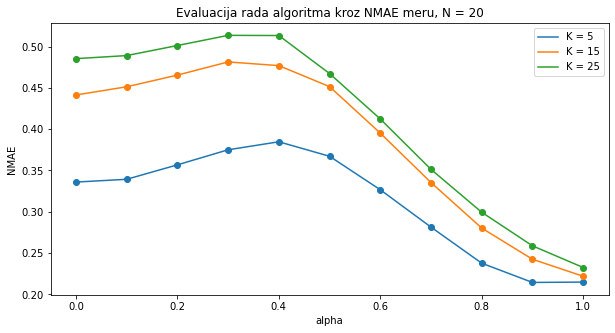

In [72]:
plt.figure(figsize = (10, 5))
plt.title('Evaluacija rada algoritma kroz NMAE meru, N = 20')
plt.plot([element[0] for element in evaluations[5]], [element[3] for element in evaluations[5]], label = 'K = 5')
plt.scatter([element[0] for element in evaluations[5]], [element[3] for element in evaluations[5]])
plt.plot([element[0] for element in evaluations[15]], [element[3] for element in evaluations[15]], label = 'K = 15')
plt.scatter([element[0] for element in evaluations[15]], [element[3] for element in evaluations[15]])
plt.plot([element[0] for element in evaluations[25]], [element[3] for element in evaluations[25]], label = 'K = 25')
plt.scatter([element[0] for element in evaluations[25]], [element[3] for element in evaluations[25]])
plt.legend(loc = 'best')
plt.xlabel('alpha')
plt.ylabel('NMAE')
plt.show()

NMAE (Normalized Mean Absolute Error) je normalizovana MAE, samim tim su rezultati slični, samo što su predstavljeni na drugoj skali - od 0 do 1. Sve što važi za MAE važi i ovde. 

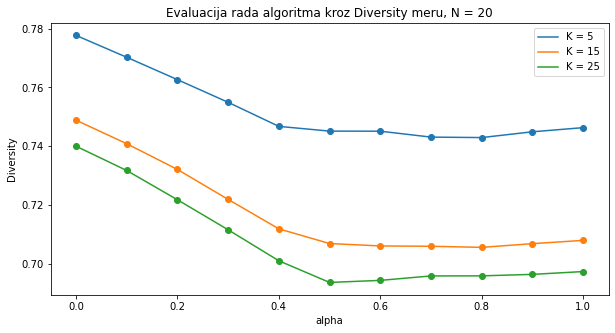

In [73]:
plt.figure(figsize = (10, 5))
plt.title('Evaluacija rada algoritma kroz Diversity meru, N = 20')
plt.plot([element[0] for element in evaluations[5]], [element[4] for element in evaluations[5]], label = 'K = 5')
plt.scatter([element[0] for element in evaluations[5]], [element[4] for element in evaluations[5]])
plt.plot([element[0] for element in evaluations[15]], [element[4] for element in evaluations[15]], label = 'K = 15')
plt.scatter([element[0] for element in evaluations[15]], [element[4] for element in evaluations[15]])
plt.plot([element[0] for element in evaluations[25]], [element[4] for element in evaluations[25]], label = 'K = 25')
plt.scatter([element[0] for element in evaluations[25]], [element[4] for element in evaluations[25]])
plt.legend(loc = 'best')
plt.xlabel('alpha')
plt.ylabel('Diversity')
plt.show()

Diverzitet je mera koja opisuje različitost između itema u rezultujućem skupu predloga (izlazu našeg algoritma). Što je veći diverzitet znači da su bolje performanse predviđanja za istu preciznost. Diverzitet je najveći kad je alfa 0, za svako K. To je zato što kad je alfa 0 uzimamo u obzir samo najraličitije korisnike i samim tim je diverzitet odnosno raznolikost predloga najveća. Kako alfa raste za bilo koje K vidimo da diverzitet opada. Brže opada za alfa od 0 do 0.5, a potom dosta sporije dok u nekim momentima i oscilira. Za fiksno alfa vidimo da diverzitet opada kako K raste, pri čemu se najviše izdvaja K = 5 za koje je diverzitet ubedljivo najveći. Diverzitet se meri na skali od 0 do 1 i poželjno je da je što veći, samim tim su rezultati dobri.

Koristimo Surprise biblioteku koja pruža korišćenje algoritama za uzajamno filtriranje da bismo uporedili performanse našeg algoritma sa već dostupnim algoritmima.

In [74]:
from surprise import SVD
from surprise import NMF
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import KNNWithZScore
from surprise import NormalPredictor
from surprise import SlopeOne
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import PredefinedKFold
import os

files_dir = os.path.expanduser('ml-100k/')

reader = Reader('ml-100k')

# ucitavamo vec postojece podele na trening i test skup da bismo tacno uporedili rezulate na nasoj podeli 
# (u1.base i u1.test)

train_file = files_dir + 'u%d.base'
test_file = files_dir + 'u%d.test'
folds_files = [(train_file % i, test_file % i) for i in (1, 2, 3, 4, 5)]

data = Dataset.load_from_folds(folds_files, reader=reader)
pkf = PredefinedKFold()

Učitavamo 8 različitih dostupnih algoritama zarad poređenja od kojih pravimo 14 modela sa različitim parametrima, pri čemu ćemo se najviše fokusirati na KNNWithMeans i KNNWithZScore, jer su njihove forme najsličnije našem algoritmu. KNNWithMeans koristi srednju vrednost ocena za jednog korisnika, kao i naš algoritam, ali koristi funkciju sličnosti umesto kovarijanse i uzima u obzir samo najsličnije korisnike, dok naš algoritam uzima u obzir i najrazličitije (zbog poboljšanja raznolikosti predloga). KNNWithZScore je veoma slična KNNWithMeans samo što uzima z-score normalizaciju za svakog korisnika. Surprise biblioteka nudi 4 funkcije sličnosti i za svaku od njih ćemo obučiti poseban model i primeniti ga na test skupu. Takođe, za algoritme koji koriste KNN svuda je naznačeno da želimo da se uzme u obzir broj suseda između 5 i 25, da bi bilo što bliže našem algoritmu u kome smo takođe proveravali za K koje je najmanje 5, a najviše 25.

In [75]:
algoSVD = SVD()
algoNMF = NMF()
algoKNN = KNNBasic(k = 25, min_k = 5)

sim_options_cos = {'name': 'cosine',
               'user_based': True  # compute similarities between users
               }

sim_options_msd = {'name': 'msd',
               'user_based': True  # compute similarities between users
               }

sim_options_pear = {'name': 'pearson',
               'user_based': True  # compute similarities between users
               }

sim_options_pear_base = {'name': 'pearson_baseline',
               'user_based': True  # compute similarities between users
               }

algoKNNMeansCOS = KNNWithMeans(k = 25, min_k = 5, sim_options = sim_options_cos)
algoKNNMeansMSD = KNNWithMeans(k = 25, min_k = 5, sim_options = sim_options_msd)
algoKNNMeansPEAR = KNNWithMeans(k = 25, min_k = 5, sim_options = sim_options_pear)
algoKNNMeansPEARBASE = KNNWithMeans(k = 25, min_k = 5, sim_options = sim_options_pear_base)

algoKNNWithZScoreCOS = KNNWithZScore(k = 25, min_k = 5, sim_options = sim_options_cos)
algoKNNWithZScoreMSD = KNNWithZScore(k = 25, min_k = 5, sim_options = sim_options_msd)
algoKNNWithZScorePEAR = KNNWithZScore(k = 25, min_k = 5, sim_options = sim_options_pear)
algoKNNWithZScorePEARBASE = KNNWithZScore(k = 25, min_k = 5, sim_options = sim_options_pear_base)

algoKNNBaseline = KNNBaseline(k = 25, min_k = 5, sim_options = sim_options_pear_base)

algoNormal = NormalPredictor()
algoSlopeOne = SlopeOne()

Za svaki od algoritama treniramo i predviđamo na odgovarajućim trening i test skupovima koje smo učitali, a potom evaluiramo pomoću MAE metrike. Surprise biblioteka nudi 4 metrike za evaluaciju, ali je MAE jedina od tih ponuđenih koju smo mi koristili prilikom evaluacije našeg algoritma pa je samim tim jedina koju ćemo uzeti u obzir i za Surprise.

In [76]:
%%time

for trainset, testset in pkf.split(data):

    algoSVD.fit(trainset)
    predictions = algoSVD.test(testset)

    accuracy.mae(predictions, verbose=True)


MAE:  0.7499
MAE:  0.7394
MAE:  0.7336
MAE:  0.7350
MAE:  0.7358
Wall time: 19.7 s


In [77]:
%%time

for trainset, testset in pkf.split(data):

    algoNMF.fit(trainset)
    predictions = algoNMF.test(testset)

    accuracy.mae(predictions, verbose = True)

MAE:  0.7659
MAE:  0.7595
MAE:  0.7536
MAE:  0.7586
MAE:  0.7592
Wall time: 20.9 s


In [78]:
%%time

for trainset, testset in pkf.split(data):

    algoKNN.fit(trainset)
    predictions = algoKNN.test(testset)

    accuracy.mae(predictions, verbose = True)

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7850
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7749
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7690
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7666
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7736
Wall time: 14.5 s


In [79]:
%%time

for trainset, testset in pkf.split(data):

    algoKNNMeansCOS.fit(trainset)
    predictions = algoKNNMeansCOS.test(testset)

    accuracy.mae(predictions, verbose = True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  0.7723
Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  0.7624
Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  0.7574
Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  0.7557
Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  0.7607
Wall time: 22 s


In [80]:
%%time

for trainset, testset in pkf.split(data):

    algoKNNMeansMSD.fit(trainset)
    predictions = algoKNNMeansMSD.test(testset)

    accuracy.mae(predictions, verbose = True)

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7644
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7553
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7515
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7496
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7544
Wall time: 15.6 s


In [81]:
%%time

for trainset, testset in pkf.split(data):

    algoKNNMeansPEAR.fit(trainset)
    predictions = algoKNNMeansPEAR.test(testset)

    accuracy.mae(predictions, verbose = True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.7599
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.7484
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.7457
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.7453
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.7514
Wall time: 21.2 s


In [82]:
%%time

for trainset, testset in pkf.split(data):

    algoKNNMeansPEARBASE.fit(trainset)
    predictions = algoKNNMeansPEARBASE.test(testset)

    accuracy.mae(predictions, verbose = True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
MAE:  0.7440
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
MAE:  0.7337
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
MAE:  0.7284
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
MAE:  0.7279
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
MAE:  0.7337
Wall time: 23.7 s


In [83]:
%%time

for trainset, testset in pkf.split(data):

    algoKNNWithZScoreCOS.fit(trainset)
    predictions = algoKNNWithZScoreCOS.test(testset)

    accuracy.mae(predictions, verbose = True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  0.7690
Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  0.7600
Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  0.7552
Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  0.7529
Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  0.7586
Wall time: 19.5 s


In [84]:
%%time

for trainset, testset in pkf.split(data):

    algoKNNWithZScoreMSD.fit(trainset)
    predictions = algoKNNWithZScoreMSD.test(testset)

    accuracy.mae(predictions, verbose = True)

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7612
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7529
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7492
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7468
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7522
Wall time: 15.5 s


In [85]:
%%time

for trainset, testset in pkf.split(data):

    algoKNNWithZScorePEAR.fit(trainset)
    predictions = algoKNNWithZScorePEAR.test(testset)

    accuracy.mae(predictions, verbose = True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.7560
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.7459
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.7427
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.7414
Computing the pearson similarity matrix...
Done computing similarity matrix.
MAE:  0.7486
Wall time: 20.9 s


In [86]:
%%time

for trainset, testset in pkf.split(data):

    algoKNNWithZScorePEARBASE.fit(trainset)
    predictions = algoKNNWithZScorePEARBASE.test(testset)

    accuracy.mae(predictions, verbose = True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
MAE:  0.7401
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
MAE:  0.7314
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
MAE:  0.7256
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
MAE:  0.7245
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
MAE:  0.7319
Wall time: 20 s


In [87]:
%%time

for trainset, testset in pkf.split(data):

    algoKNNBaseline.fit(trainset)
    predictions = algoKNNBaseline.test(testset)

    accuracy.mae(predictions, verbose = True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
MAE:  0.7317
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
MAE:  0.7216
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
MAE:  0.7187
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
MAE:  0.7193
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
MAE:  0.7261
Wall time: 20.8 s


In [88]:
%%time

for trainset, testset in pkf.split(data):

    algoNormal.fit(trainset)
    predictions = algoNormal.test(testset)

    accuracy.mae(predictions, verbose = True)

MAE:  1.2433
MAE:  1.2266
MAE:  1.2119
MAE:  1.2190
MAE:  1.2164
Wall time: 2.45 s


In [89]:
%%time

for trainset, testset in pkf.split(data):

    algoSlopeOne.fit(trainset)
    predictions = algoSlopeOne.test(testset)

    accuracy.mae(predictions, verbose = True)

MAE:  0.7506
MAE:  0.7423
MAE:  0.7427
MAE:  0.7402
MAE:  0.7436
Wall time: 13.1 s


Ako posmatramo samo prvu vrednost za MAE od 5 koji su dati u svakom algoritmu (zato što naš algoritam je koristio prvu podelu na trening i test skup), videćemo da se vrednost uglavnom kreće od 0.75 do 0.8, izuzev algoNormal koji je otprilike 1.24. Ako u našem algoritmu izaberemo alfa = 0.8 i K = 5 kao optimalnu kombinaciju za sve 4 metrike dobijamo da je MAE 0.95, što je lošije od 13 modela na kojima se vrednost MAE kreće između 0.75 do 0.8. Možemo zaključiti da naš model daje lošije rezultate za MAE od već dostupnih modela.

Algoritam koji je ovde implementiran bi trebalo da poboljša diverzitet u sistemima preporuka. Možda je veća MAE vrednost upravo cena koja je morala da se plati da bi se diverzitet poboljšao. Nažalost, nemamo uvid u meru diverziteta kod sistema koje pruža Surprise biblioteka, pa samim tim ne možemo da uporedimo. 